# CSE527 Homework 3 - Part 2
**Due date: 23:59 on Nov 26, 2023**


## Description
---
Detection is a fundamental task in CV. This homework is on based on DETR (https://arxiv.org/abs/2005.12872), one of the most famous yet simple detection model.

In this part, you will get familiar with DETR code base and will be modfiying the code (https://github.com/facebookresearch/detr/tree/main) to perfrom a new task: **_Detection using Centroids_**.

Traditionally bounding boxes are used to highlight detections, however in this homework you will perfrom detection of an object by selecting a _meaningful_ center point on it. We will call that point the centroid. For applications involving peculiar objects (like Giraffes,), where the center of the bounding box may not lie on the objects main body, a centroid detection may be more useful.    
  





## Code
---
Although DETR is simple relative to other detection models, the code to train and test is still complex and is spread acorss multiple directories. For this reason, the code is provided in a zipped package (here [detr.zip](https://drive.google.com/file/d/1GuserI8EDxAlTG4eh98JhugVsSDWCS3f/view?usp=sharing)).

To pull this code into your colab, you have to first add the zip file as shortcut to current working directory. To do this, open the above link and click on "Add shortcut to Drive" button (drive symbol with a plus) and navigate to working current directory and add shortcut.

You have to repeat the same process to download this [coco.zip dataset](https://drive.google.com/file/d/1GVyxYHwVgiG9z_Sn46wslT_2n65DLZRw/view?usp=sharing).

In [1]:
HW3_ROOT_PATH = '/gdrive/MyDrive/' + 'CSE527/Segireddy_RutwikReddy_115936140_hw3/' #'FILL IN YOUR HOMEWORK3 ROOT HERE'
PATH_TO_PART2 = HW3_ROOT_PATH + 'part2/'
PATH_TO_COCO = HW3_ROOT_PATH + 'coco/'
# TRY to use these variable wherever you load/save some file

In [2]:
from google.colab import drive
drive.mount('/gdrive')
# CD into root of your homework2 part3 directory
%cd -q $PATH_TO_PART2

Mounted at /gdrive


In [3]:
!ls

CSE527_23F_HW3_P2.ipynb  detr  detr.zip


In [4]:
!unzip -n detr.zip

In [5]:
%cd detr
%mkdir checkpoints

/gdrive/MyDrive/CSE527/Segireddy_RutwikReddy_115936140_hw3/part2/detr


## Install dependencies
---
If you are using colab, running below cell will suffice, else refer to requirements.txt to install all dependencies

In [6]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-qdp3nk45
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-qdp3nk45
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375459 sha256=61d933e81c100b6fe794f69b1ce0dc4c6206570ad7b8147569d2a89a9f714723
  Stored in directory: /tmp/pip-ephem-wheel-cache-tzx0b2j8/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


##Model
---
DETR consists of
- a feature extractor,
- transformer and
- two output heads
    - classification head
    - regression head

In the original implementation, regression head is designed to output the bouding box attributes ltrb (left, top, right, & bottom edges of object). In this homework we intend to train the model to output the centeroids of each object.

###How do we define centroids:###
Original DETR uses the MS COCO's _bbox_ annotations to train the model, while in this HW we will use the _segmentation_ annotations.
Each image may have multiple objects. The pixel outline of each object is provided as an annotation. We will use this contour information to generate the object mask.


In the below image, you can see that centroid is near the biggest portion of the object body.  
![](https://drive.google.com/uc?export=view&id=1CNym_GFV8EKwTQPZQSHZdPB7P-3qarEm)




## Get yourself familiar with Data set
---

To get your self familiar with the dataset, you are encouraged to play around with the COCO API. The sample code  given below displays the segmentation data format. In the later sections you will be yusing the segmentation data to estimate a centroid.  

In [7]:
from pycocotools.coco import COCO
from PIL import Image
from hubconf import _make_detr
import torch
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import torchvision.transforms as T

coco = COCO('instances_train2017.json')
ids = coco.getImgIds()
sample = 0
im = coco.loadImgs(ids[sample])[0]
print(f'Image keys: {im.keys()}')
annos = coco.loadAnns(coco.getAnnIds(ids[sample]))
# Note: segmentation annotation is in the format of [x1, y1, x2, y2, x3, y3, . . . ], where (x1, y1) is a point
# on countour, x being dist from left and y is dist from top row of image
print(f'Anno segmentation: {(annos[0]["segmentation"])}')
############# (0 points) ########################


#################################################


loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
Image keys: dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])
Anno segmentation: [[318.97, 254.35, 328.71, 199.41, 339.35, 164.86, 343.78, 154.23, 336.69, 135.62, 349.09, 145.37, 365.93, 145.37, 372.13, 137.39, 380.1, 145.37, 397.82, 146.25, 436.81, 148.02, 472.25, 159.54, 506.8, 175.49, 536.93, 188.78, 579.46, 202.07, 617.56, 205.62, 640.0, 199.41, 637.94, 349.15, 590.09, 351.81, 547.56, 334.98, 501.49, 317.25, 511.23, 349.15, 510.35, 376.62, 516.55, 407.63, 505.03, 407.63, 498.83, 381.93, 497.94, 407.63, 480.22, 405.86, 474.02, 367.76, 459.85, 316.37, 437.69, 284.47, 432.38, 257.89, 412.89, 230.42, 391.62, 210.05, 380.1, 222.45, 363.27, 233.97, 357.95, 251.69, 346.43, 259.66, 330.49, 264.98]]


## Complete the code
---

This provided detr/ folder has the following structure
```
detr/
├── datasets/
│   ├── coco.py
│   ├── ...
├── models/
│   ├── detr.py
│   ├── matcher.py
│   └── ...
├── utils/
│   └── ...
├── engine.py
├── main.py
├── requirements.txt
└── README.md
```

In these python files, you will be implementing the missing code blocks. These blocks are highlited by the TODOs
```#### TODO CSE527 STUDENT CODE STARTS HERE ######```


In total there are 5 sections the code has to be filled. They are located in the files: coco.py, detr.py, matcher.py.  

To complete this part you are very much encouraged to:
- understand how dataset, data sampler, dataloader, model, loss, & optimizer work together during training  
- refer to the actual DETR implementation at [git:facebookresearch/detr](https://github.com/facebookresearch/detr/tree/main) to get an idea of the training pipeline.
- try to understand flow of control from main.py.

You cannot complete the missing code blocks just from the given description in this ipynb, so you must read the code around. That is, you will read the inputs, outputs and how the inputs to the code block are created and how the outputs from the code block will be utilized.   

## Task
You should modify the DETR to output centroids rather than bounding boxes.   
Dataset:
At the dataset level, you are not actually given the centroids, so you will use the instance segmentation masks to estimage the centroid for each object in annotation.

Model:
For this you will need to replace the classification and regression heads (already removed in the code provided to you, you just need to add new).



### 1 - coco.py: ConvertCocoPolysToMask.\__call__()  [20 points]
Here you will be writing the logic to convert annotations to centroids in the following method.
Note: You will have to figure out the inputs and outputs by yourself.  
```
def convert_coco_poly_to_centroids(segmentations, h, w, boxes) -> Torch.Tensor(shape = num_segmentations x 2)
```

This method is part of data loader, and is called when generating the <sample, prediction> pairs, which will eventually be passed onto model for training.

The _centroid_ we are referring to is a hypothetical point on the center of the object's main body part. It should ideally never be a point outside the annotation mask, and is likley always in the middle of body. Here in our case centroid should lie on the middle of horse's torso.

steps:
 - convert segmentations into masks [5 points]
 - figure out a way to remove thin sections of object (legs and tail of the horse) from the mask, so only the largest body part (torso) will influence the centroid [10 points]
 - compute the center of mass of the mask [5 point]

 Feel free to pass on more inputs/outputs to the above method to support your way of computing centroids.


### 2 & 3 - detr.py: DETR.\__init__(), DETR.forward() [10 points]

This is the DETR model architectrure. Here you will change the classification and regression heads, so the model can output centroids (unlike bboxes in original implementation).
Also you will write logic to freeze the remaining section of DETR.

Original model takes 300 hours to completely train from scrtch, so it is important to freeze all weights except necessary ones (heads).

### 4 - matcher.py: HungarianMatcher.forward() [15 points]

Matcher is a key part of detection models. Refer to the paper or original DETR implementation to see how/why matcher is used. In this implementation we use Hungarian algorithm to align predictions to the ground truths.

Breif:  
All object instance predictions are matched against the ground truth objects. This is necessary to compute the loss.
Basically matcher will guess which ground truth object each prediction might be referring based on the closeness of predicted centroids and ground truth centroids.

100 centroid predictions will be matched against the ground truth centroids. You will compute a cost matrix that encdes the relation of prediction to GT.

Refer: https://en.wikipedia.org/wiki/Hungarian_algorithm

How you compute the cost matrix is again upto you.

### 5 - detr.py: SetCriterion.loss_centroid() [10 points]

Here you will implement the loss function. Given the predicted centroids and ground truth centroids (which you processed in coco.py), you will write logic to compute variable _centroid_loss_

The loss method is up to you.  

Note: At code blocks 4 & 5, make sure the loss/cost is in the normalized range only. I.e., loss/cost is calculated on normalized inputs.




## Computing centroid
---

Below block provide you a sandbox environment to play around and create a centroid finding algorithm. You will eventually use this code at detr/dataset/coco.py to complete the traning pipeline.

Try to produce centroids that are within 10 pixels a far from the provided gt centroids.

In [8]:
import torch
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from scipy.ndimage import binary_erosion
from pycocotools import mask as coco_mask

def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks

def convert_coco_poly_to_centroids(segmentations, height, width, bboxes):
    """Converts COCO polygon annotations to centroids.
    Args:
        segmentations: A list of COCO polygon annotations.
        height: The height of the image.
        width: The width of the image.
        boxes: bounding boxes

    Returns:
        A PyTorch tensor containing the centroids of the objects in the image.
    """
    masks = convert_coco_poly_to_mask(segmentations, height, width)
    centroids = []
    for mask in masks:
        kernel = np.ones((8, 8))
        new_mask = binary_erosion(mask, kernel, 3)

        if (new_mask == 1).sum() == 0:
            y_centroid, x_centroid = np.argwhere(mask.numpy() == 1).sum(0) / (mask.numpy() == 1).sum()
        else:
            y_centroid, x_centroid = np.argwhere(new_mask == 1).sum(0) / (new_mask == 1).sum()

        centroids.append([x_centroid, y_centroid])
    return torch.tensor(centroids).float()

Predicted centroids: tensor([[377.8110, 307.6467],
        [538.4375, 259.3125]])


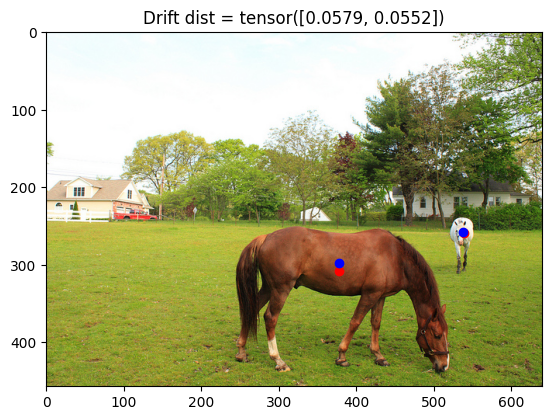

In [9]:
def estimate_centroids(img, anns):
    h, w = img['height'], img['width']
    # Get segmentations and convert them to centroids
    segmentations = [ann['segmentation'] for ann in anns]
    boxes = [obj["bbox"] for obj in anns]
    boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=w)
    boxes[:, 1::2].clamp_(min=0, max=h)
    return convert_coco_poly_to_centroids(segmentations, h, w, boxes)


def compute_drift_rate(centroids, gt_centroids, gt_areas):
  distance_matrix = torch.cdist(centroids, gt_centroids)
  distances = []
  equivalent_lengths = []
  for i in range(len(centroids)):
      min_distance = torch.min(distance_matrix[i])
      min_distance_index = torch.argmin(distance_matrix[i])
      distances.append(min_distance)
      equivalent_lengths.append(np.sqrt(gt_areas[min_distance_index]))
  return torch.div(torch.Tensor(distances), torch.Tensor(equivalent_lengths))


# driver code
img_id = 144505
img = coco.loadImgs(img_id)[0]
img_data = Image.open(requests.get(img['coco_url'], stream=True).raw)

# Get image annotations
anns = coco.loadAnns(coco.getAnnIds(img_id))
centroids = estimate_centroids(img, anns)
gt_centroids = torch.Tensor([[378, 298],[537, 258]])
print(f'Predicted centroids: {centroids}')
plt.imshow(img_data)
for centroid in centroids:
    plt.plot(centroid[0], centroid[1], 'ro')
for centroid in gt_centroids:
    plt.plot(centroid[0], centroid[1], 'bo')

# Show image
plt.title(f'Drift dist = {compute_drift_rate(centroids, gt_centroids, [ann["area"] for ann in anns])}')
plt.show()



## Training
---

Implement all five mentioned code blocks and use the below command AS IS. You can change BS, num_epochs, num_workers. (use this output training  [log](https://drive.google.com/file/d/1ZGd-ciOKkajri0GEOwc-uJDBjGJHJdNY/view?usp=drive_link) for your reference).

Make sure checkpoints are being saved correctly and sometime not mistakenly being overriden due to multiple executions.

You can use the validation loss/loss_centroid  as a metric to track performance.

For grading:
- There are no strict limits on evaluation metrics.
- In the last cell of this notebook _avg_drift_rate_ metric is computed on a subset of validation ds. Try to score below 0.35.





In [10]:
!python -u main.py --coco_path $PATH_TO_COCO --batch_size 10 --num_workers 12 --epochs 20 --output_dir './checkpoints'  --resume https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth --freeze_body

Not using distributed mode
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
git:
  sha: N/A, status: clean, branch: N/A

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=10, weight_decay=0.0001, epochs=20, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, freeze_body=True, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_centroid=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, cent_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path='/gdrive/MyDrive/CSE527/Segireddy_RutwikReddy_115936140_hw3/coco/', coco_panoptic_path=None, remove_difficult=False, output_dir='./checkpoints', device='cuda', seed=42, resume='https://dl.fbaipublicfiles.com/d

## Visualizing
---------------

In [11]:
device = torch.device('cuda')
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



def rescale_center(out_bbox, size):
    img_w, img_h = size
    b = out_bbox * torch.tensor([img_w, img_h], dtype=torch.float32, device=device)
    return b

def detect(im, model, transform, det_threshold = 0.75):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img.to(device))

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > det_threshold

    # convert boxes from [0; 1] to image scales
    centroids = rescale_center(outputs['pred_centroids'][0, keep], im.size)
    return probas[keep].detach().cpu(), centroids.detach().cpu()

def getImg(url):
    return Image.open(requests.get(url, stream=True).raw)

def is_grayscale(image):
    if image.mode == "L":
        return True
    else:
        return False

def convert_grayscale_to_rgb(image):
    if not is_grayscale(image):
        return image
    else:
        return image.convert("RGB")


def plot_results(pil_img, prob, centroids, gt_centroids, boxes, file_name):
    # plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    ax.scatter([c[0] for c in gt_centroids], [c[1] for c in gt_centroids], color='blue', s=10)
    ax.scatter([c[0] for c in centroids], [c[1] for c in centroids.cpu()], color='red', s=10)
    if show_center:
        ax.scatter([c[0]+c[2]//2 for c in boxes], [c[1]+c[3]//2 for c in boxes], color='green', s=10)
    for (xc, yc, w, h), c in zip(boxes, COLORS * 100):
        ax.add_patch(plt.Rectangle((xc, yc), w, h,
                                   fill=False, color='white', linewidth=2))
    if show_probs:
        for p, c in zip(prob, centroids):
            cl = p.argmax()
            text = f'- {p[cl]:0.2f}'
            ax.text(c[0] + 15, c[1], text, fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    # plt.savefig(f'images/{file_name}')
    plt.show()



### before submission run below cell with display_results=True

In [12]:

display_results = True
show_probs = True
show_center = True
det_threshold = 0.7

model = _make_detr('resnet50', num_classes=2)
model.to(device)

checkpoint = torch.load('checkpoints/checkpoint.pth', map_location='cpu')
print("DETR returning", {n:p for n,p in model.named_parameters()}.keys())

model.load_state_dict(checkpoint['model'])
model.eval()
if not os.path.exists('images'):
    os.mkdir('images')

coco = COCO(PATH_TO_COCO + 'annotations/instances_val2017.json')
ids = coco.getImgIds()

val_drift_rates = []
for id in range(20):
    im = coco.loadImgs(ids[id])[0]
    annos = coco.loadAnns(coco.getAnnIds(ids[id]))
    img = getImg(im['coco_url']).convert("RGB")
    scores, centroids = detect(img, model, transform, det_threshold=det_threshold)
    gt_centroids = estimate_centroids(im, annos)
    plot_results(img, scores, centroids, gt_centroids, [anno['bbox'] for anno in annos], im['file_name'])
    drift_rates = compute_drift_rate(centroids, gt_centroids, [anno['area'] for anno in annos])
    print(f'im: {ids[id]}, drift rates : {drift_rates.cpu().numpy()}')
    val_drift_rates.append(drift_rates)

overall_drit_rates = torch.concat(val_drift_rates, dim=0)
print(f'Average drift rate: {overall_drit_rates.mean()}')

Output hidden; open in https://colab.research.google.com to view.

Average Drift Rate: 0.2972410321235657

## Discussion
---
**write 1 up to 3 sentences for each question**
1. ***What is your intution behind your implementation of  coco.py:convert_coco_poly_to_centroids()*** [2 points]
- This problem involves computing the centroid from given polygon coordinates of a segmentation and is described below:

    - Compute the mask for the segmentation using the provided function `convert_coco_poly_to_mask`.
    - Before utilizing the mask to calculate the centroid, it's necessary to modify the mask to emphasize the torso of the horse. This involves removing segments of the mask to prioritize the torso's influence on the centroid. Employing a square kernel consisting of all ones on the mask can eliminate sections such as legs and the tail, focusing on preserving areas with larger height and width while removing thin sections either horizontally or vertically.
    - However, in cases involving smaller horses, this operation might eliminate the entire horse. In such scenarios, this operation is skipped to preserve the mask.
    - Determine the centroid from the mask by applying a weighted average formula. Since the mask values are binary (0 or 1), this translates into averaging the x and y coordinates for each pixel with a mask value of 1. Note the reversal of x and y coordinates as we are dealing with images with dimensions height and width.
    - Each segmentation corresponds to a single horse, resulting in a list of centroids with a length equal to the number of segmentations.


2. ***Which distance metric have you used for computing the cost matrix between centroids? why?*** [1 points]
- I have applied the L1 loss (Manhattan Distance) to compute the cost matrix among centroids.
- This loss calculates distances by summing the absolute differences of their coordinates. I chose this metric for its robustness against outliers.
- However, when applied to bounding boxes, the L1 loss presents a challenge: for two differently shaped boxes with a similar relative error, the absolute error would significantly differ. To address this, the loss is often combined with the GIoU loss to mitigate this discrepancy. Fortunately, in our case, as we are dealing solely with centroids, the L1 loss is appropriate and avoids this issue.

3. ***Why freezing the entire model and traning just the heads might never actually predict the true centroids?*** [2 points]

- When you freeze all layers except the heads in a neural network, you stop the model from adjusting the earliest layers. These layers usually find basic features in the data. So, without updating them, the model might struggle to catch complex details and relationships needed for accurate centroid predictions.
- But if you only train the heads, the model's ability to fine-tune its feature extraction is restricted. It is stuck using features from the frozen layers, which might limit how well it can understand complex patterns in the data.







## Submission guidelines
---



The submission structure should look like:

IMPORTANT: Remove the _checkpoint.pth_ and make sure _heads.pth_ is in the submission.


```
{last name}_{first name}_{sbu id}_hw2/
├── part1/
│   └── ...
├── part2/
│   ├── CSE527_23F_HW3_P2.ipynb
│   └── detr/
│       ├── checkpoints/
│       │   └── heads.pth
│       ├── datasets/
│       │   ├── coco.py
│       │   ├── ...
│       │   └── ...
│       ├── models/
│       │   ├── detr.py
│       │   ├── matcher.py
│       │   ├── ...
│       │   └── ...
│       ├── utils/
│       │   ├── ...
│       │   └── ...
│       ├── engine.py
│       ├── main.py
│       ├── hubconf.py
│       └── requirements.txt
```


Follow instructions in part1's submission guidelines to generate your complete submission